In [ ]:
# Cell 1: Load existing trained model (if present) and verify environment'
#pip  install stable_baselines3
import os
import gymnasium as gym
import ale_py  # ensure ALE namespace is registered
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack

ENV_ID = "ALE/Pong-v5"

# Recreate the same preprocessing used for CNN training: make_atari_env + 4-frame stack
try:
    env = make_atari_env(ENV_ID, n_envs=1, seed=42)
    env = VecFrameStack(env, n_stack=4)
except Exception as e:
    raise RuntimeError(
        f"Failed to build Atari VecEnv for {ENV_ID}. Ensure ale-py and ROMs are installed. Original error: {e}"
    )
env.close()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# Cell 2: Reusable training function for hyperparameter experiments (CNN policy)
# !pip install -q stable_baselines3
import time, os, datetime, csv
import pandas as pd
from typing import Dict, Tuple

from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy

# Callback to record and PRINT episode stats; also saves a CSV and a .log per run
class EpisodeCSVLogger(BaseCallback):
    def __init__(self, run_name: str, csv_path: str, log_path: str, verbose: int = 1):
        super().__init__(verbose)
        self.run_name = run_name
        self.csv_path = csv_path
        self.log_path = log_path
        self.rows = []

    def _on_training_start(self) -> None:
        os.makedirs(os.path.dirname(self.csv_path), exist_ok=True)
        os.makedirs(os.path.dirname(self.log_path), exist_ok=True)
        with open(self.log_path, "a", encoding="utf-8") as f:
            f.write(f"[{self._ts()}] [RUN {self.run_name}] logging started\n")

    def _on_step(self) -> bool:
        # VecEnv infos may contain 'episode' dict when an episode ends
        for info in self.locals.get("infos", []):
            if "episode" in info:
                ep = info["episode"]
                ep_len = ep.get("l", None)
                ep_rew = ep.get("r", None)
                self.rows.append((self.num_timesteps, ep_len, ep_rew))
                # Try to fetch current exploration rate (DQN attribute)
                eps = getattr(self.model, "exploration_rate", None)
                line = f"[{self._ts()}] [RUN {self.run_name}] t={self.num_timesteps} | episode_end len={ep_len} reward={ep_rew:.2f}"
                if eps is not None:
                    line += f" | eps={eps:.4f}"
                print(line, flush=True)
                with open(self.log_path, "a", encoding="utf-8") as f:
                    f.write(line + "\n")
        return True

    def _on_training_end(self) -> None:
        with open(self.csv_path, "w", newline="", encoding="utf-8") as f:
            w = csv.writer(f)
            w.writerow(["timestep", "ep_length", "ep_reward"])
            w.writerows(self.rows)
        if self.verbose:
            print(f"Saved episode CSV to {self.csv_path}")
        with open(self.log_path, "a", encoding="utf-8") as f:
            f.write(f"[{self._ts()}] [RUN {self.run_name}] episode CSV saved -> {self.csv_path}\n")

    @staticmethod
    def _ts() -> str:
        return datetime.datetime.now().strftime("%H:%M:%S")


def make_cnn_env(seed: int):
    env = make_atari_env(ENV_ID, n_envs=1, seed=seed)
    env = VecFrameStack(env, n_stack=4)
    return env


def train_experiment(name: str, hp: Dict, total_timesteps: int = 50_000, seed: int = 42, eval_episodes: int = 3) -> Tuple[Dict, DQN]:
    """
    Train a DQN(CnnPolicy) model with given hyperparameters.
    Returns (metrics_dict, model) WITHOUT saving the model; caller saves.
    """
    os.makedirs("logs", exist_ok=True)
    os.makedirs("models", exist_ok=True)

    env = make_cnn_env(seed)
    csv_log = os.path.join("logs", f"training_metrics_{name}.csv")
    run_log = os.path.join("logs", f"run_{name}.log")
    callback = EpisodeCSVLogger(run_name=name, csv_path=csv_log, log_path=run_log, verbose=1)

    # Remove optimize_memory_usage to avoid conflict with handle_timeout_termination (ValueError)
    model = DQN(
        "CnnPolicy",
        env,
        seed=seed,
        tensorboard_log=os.path.join("logs", "tensorboard", name),
        optimize_memory_usage=False,  # changed from True to False to fix replay buffer conflict
        **hp,
    )

    start_msg = f"[{datetime.datetime.now().strftime('%H:%M:%S')}] [RUN {name}] START Training {total_timesteps} steps | hp={hp}"
    print(start_msg, flush=True)
    with open(run_log, "a", encoding="utf-8") as f:
        f.write(start_msg + "\n")

    t0 = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback, progress_bar=True)
    minutes = (time.time() - t0) / 60.0

    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=eval_episodes)
    env.close()

    end_msg = f"[{datetime.datetime.now().strftime('%H:%M:%S')}] [RUN {name}] END mean_reward={mean_r:.2f} ± {std_r:.2f} | train_minutes={minutes:.2f}"
    print(end_msg, flush=True)
    with open(run_log, "a", encoding="utf-8") as f:
        f.write(end_msg + "\n")

    metrics = {
        "name": name,
        "mean_reward": float(mean_r),
        "std_reward": float(std_r),
        "train_minutes": minutes,
        **hp,
    }
    return metrics, model

print("Training function ready. Configure hyperparameter sets in next cell.")

Training function ready. Configure hyperparameter sets in next cell.


In [3]:
# Cell 3: Define TEN hyperparameter experiment configurations (CNN policy)
# Expanded from 5 to 10 for broader tuning coverage.
# Strategy: vary learning rate, buffer size, batch size, gamma, exploration schedule, and target update interval.

experiments = [

    # 10 Larger gradient steps per update
    {
        "name": "exp10_more_gradient_steps",
        "hp": dict(
            learning_rate=1e-4,
            gamma=0.99,
            batch_size=32,
            buffer_size=100_000,
            train_freq=4,
            gradient_steps=4,  # perform multiple gradient steps per collection
            target_update_interval=10_000,
            exploration_fraction=0.1,
            exploration_initial_eps=1.0,
            exploration_final_eps=0.01,
            verbose=0,
        ),
    },
]

print(f"Prepared {len(experiments)} experiment configs.")

Prepared 1 experiment configs.


In [ ]:
# Cell 4: Run experiments, SAVE EACH model, also keep a 'best' copy, and build results table
import os, gc, shutil
TOTAL_TIMESTEPS = 500_000  # increase for better learning (e.g., 500_000 or more)
SEED = 42
EVAL_EPISODES = 3
BEST_MODEL_PATH = os.path.join("models", "best_dqn_pong_cnn.zip")

results = []
best_record = None
best_mean_reward = None

os.makedirs("models", exist_ok=True)

for exp in experiments:
    name = exp["name"]
    hp = exp["hp"]

    try:
        metrics, model = train_experiment(
            name=name,
            hp=hp,
            total_timesteps=TOTAL_TIMESTEPS,
            seed=SEED,
            eval_episodes=EVAL_EPISODES,
        )
        # Save this run's model
        model_path = os.path.join("models", f"{name}.zip")
        model.save(model_path)
        print(f"[SAVE] {name} -> {model_path}", flush=True)

        # Track best and keep a copy as 'best'
        if (best_mean_reward is None) or (metrics["mean_reward"] > best_mean_reward):
            best_mean_reward = metrics["mean_reward"]
            best_record = dict(metrics)
            # Save/overwrite the single best model copy
            model.save(BEST_MODEL_PATH)
            print(f"[BEST] Updated: {name} -> {BEST_MODEL_PATH} (mean_reward={best_mean_reward:.2f})", flush=True)

        # Add path to metrics row and store
        metrics["model_path"] = model_path
        results.append(metrics)

    except MemoryError:
        print(f"[SKIP] {name} ran out of memory. Consider lowering buffer_size.", flush=True)

    finally:
        # Free GPU/RAM as we go
        try:
            del model
        except Exception:
            pass
        gc.collect()

import pandas as pd
results_df = pd.DataFrame(results)
# Sort for easier viewing
if not results_df.empty and "mean_reward" in results_df.columns:
    results_df = results_df.sort_values("mean_reward", ascending=False).reset_index(drop=True)
    print("Top result:")
    print(results_df.head(1))
results_df

   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284/500,000  [ 0:00:01 < 1:00:01 , 139 it/s ]

In [5]:
# Cell 5: Save results table as branis_models.csv (sorted by mean_reward)
import os
os.makedirs("logs", exist_ok=True)
results_csv = os.path.join("logs", "branis_models.csv")
results_df.to_csv(results_csv, index=False)
print(f"Saved results table to {results_csv}")
results_df

Saved results table to logs/branis_models.csv


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,name,mean_reward,std_reward,train_minutes,learning_rate,gamma,batch_size,buffer_size,train_freq,gradient_steps,target_update_interval,exploration_fraction,exploration_initial_eps,exploration_final_eps,verbose,model_path
0,exp10_more_gradient_steps,6.666667,3.399346,81.02906,0.0001,0.99,32,100000,4,4,10000,0.1,1.0,0.01,0,models/exp10_more_gradient_steps.zip


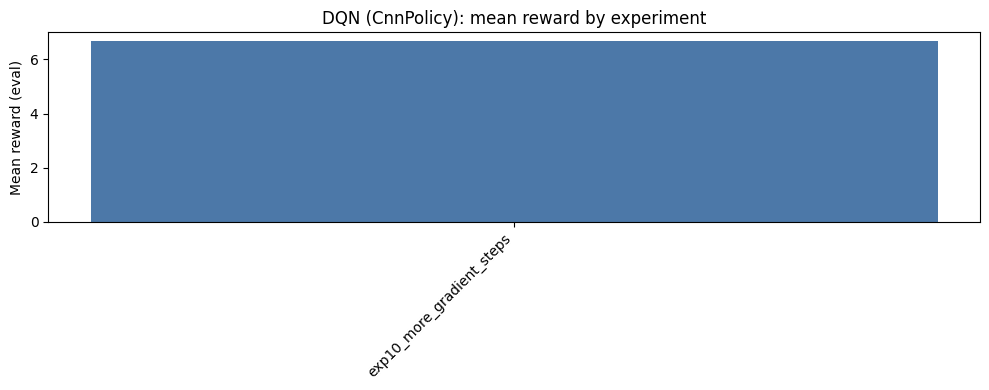

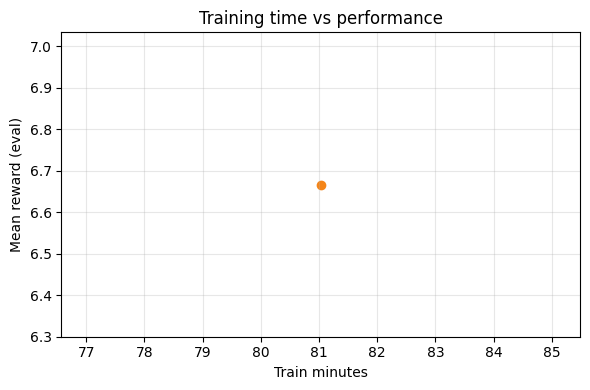

In [6]:

import matplotlib.pyplot as plt
import numpy as np

# Ensure results_df exists and is sorted by mean_reward
_df = results_df.copy()
if "mean_reward" in _df.columns:
    _df = _df.sort_values("mean_reward", ascending=False)

# Bar chart: mean_reward by experiment
plt.figure(figsize=(10, 4))
plt.bar(_df["name"], _df["mean_reward"], color="#4c78a8")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean reward (eval)")
plt.title("DQN (CnnPolicy): mean reward by experiment")
plt.tight_layout()
plt.show()

# Scatter: train_minutes vs mean_reward
if "train_minutes" in _df.columns:
    plt.figure(figsize=(6, 4))
    plt.scatter(_df["train_minutes"], _df["mean_reward"], color="#f58518")
    plt.xlabel("Train minutes")
    plt.ylabel("Mean reward (eval)")
    plt.title("Training time vs performance")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [1]:
# Cell 6: Play a saved (or best) model with on-screen rendering and robust load handling
import os, time, sys
import gymnasium as gym
import ale_py  # ensure ALE namespace is registered
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.save_util import load_from_zip_file

# Attempt to patch older saved references expecting 'numpy._core.numeric'
try:
    import numpy.core.numeric as _numeric
    if 'numpy._core.numeric' not in sys.modules:
        sys.modules['numpy._core.numeric'] = _numeric
except Exception:
    pass

BEST_MODEL_PATH = os.path.join('models', '300000/best_dqn_pong_cnn.zip')
MODEL_TO_PLAY = BEST_MODEL_PATH  # set to a specific experiment zip to test that model
N_EPISODES = 1
SEED = 42

# For pure inference we can use a small replay buffer to avoid huge RAM usage
INFERENCE_BUFFER_SIZE = 1_000  # reduce if memory is very tight (e.g., 200)


def list_models():
    if os.path.isdir('models'):
        zips = [f for f in sorted(os.listdir('models')) if f.endswith('.zip')]
        if not zips:
            print('No model .zip files found in models/')
        else:
            print('Available models:')
            for f in zips:
                print(' -', os.path.join('models', f))

if not os.path.isfile(MODEL_TO_PLAY):
    print('Model not found:', MODEL_TO_PLAY)
    list_models()
else:
    print(f'Loading model: {MODEL_TO_PLAY}')
    env = make_atari_env(ENV_ID, n_envs=1, seed=SEED, env_kwargs={'render_mode': 'human'})
    env = VecFrameStack(env, n_stack=4)

    model = None
    try:
        # First try to load while overriding large memory settings
        model = DQN.load(
            MODEL_TO_PLAY,
            env=env,
            custom_objects={
                'buffer_size': INFERENCE_BUFFER_SIZE,
                'learning_starts': 0,
                # keep other saved params; we only downsize memory-heavy ones
            },
        )
    except ModuleNotFoundError as e:
        print('[WARN] ModuleNotFoundError during load:', e)
        try:
            import numpy.core.numeric as _numeric
            sys.modules['numpy._core.numeric'] = _numeric
            print('[INFO] Patched numpy._core.numeric; retrying load...')
            model = DQN.load(
                MODEL_TO_PLAY,
                env=env,
                custom_objects={'buffer_size': INFERENCE_BUFFER_SIZE, 'learning_starts': 0},
            )
        except Exception as e2:
            print('[WARN] Patch retry failed:', e2)
    except (ValueError, MemoryError) as e:
        # Handle numpy RNG pickle mismatch or large buffer memory error
        print('[WARN] Direct load failed (ValueError/MemoryError):', e)
    except Exception as e:
        print('[WARN] Unexpected error on direct load:', e)

    if model is None:
        print('[INFO] Falling back to parameter-only load (skipping metadata)...')
        try:
            # Avoid deserializing JSON data that can contain incompatible RNG objects
            _data, params, _vars = load_from_zip_file(MODEL_TO_PLAY, device='cpu', load_data=False, print_system_info=False)
            # Instantiate a fresh lightweight DQN for inference only (small buffer, no training planned)
            model = DQN(
                'CnnPolicy',
                env,
                seed=SEED,
                verbose=0,
                buffer_size=INFERENCE_BUFFER_SIZE,
                learning_starts=0,
                train_freq=4,
                gradient_steps=1,
                exploration_fraction=0.0,
                exploration_initial_eps=0.0,
                exploration_final_eps=0.0,
            )
            model.set_parameters(params, exact_match=False)
            print('[OK] Parameters loaded in fallback mode with tiny buffer_size =', INFERENCE_BUFFER_SIZE)
        except MemoryError as me:
            print('[FAIL] MemoryError even with reduced buffer_size:', me)
            print('Try lowering INFERENCE_BUFFER_SIZE further (e.g., 200) or close other apps to free RAM.')
            env.close()
            raise
        except Exception as e3:
            print('[FAIL] Fallback weight-only load failed:', e3)
            env.close()
            raise

    # Run deterministic episodes
    for ep in range(N_EPISODES):
        obs = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, rewards, dones, infos = env.step(action)
            ep_reward += float(rewards[0])
            done = bool(dones[0])
            time.sleep(1/60)  # ~60 FPS pacing
        print(f'Episode {ep+1} return: {ep_reward:.2f}')
    env.close()

print('Done.')

Model not found: models\300000/best_dqn_pong_cnn.zip
Done.
